### Open questions

Open questions:

1. How to normilize. During center point loss do we devide per all objects in the sequence?

### Model

#### LSTM

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCenterNetWithLSTM(nn.Module):
    def __init__(self, num_objects=5, num_classes=10, lstm_hidden_size=64):
        super(SimpleCenterNetWithLSTM, self).__init__()
        self.num_objects = num_objects
        self.num_classes = num_classes
        self.lstm_hidden_size = lstm_hidden_size

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Fully connected layers for feature extraction
        self.fc1 = nn.Linear(64 * 8 * 8, 128)

        # LSTM layer to capture temporal dependencies
        self.lstm = nn.LSTM(
            input_size=128,  # Input size from fc1 layer
            hidden_size=lstm_hidden_size,
            num_layers=1,
            batch_first=False
        )

        self.hidden_h0 = nn.Parameter(torch.randn(1, 1, self.lstm_hidden_size))
        self.hidden_c0 = nn.Parameter(torch.randn(1, 1, self.lstm_hidden_size))

        # Output layers after LSTM
        self.fc_temporal = nn.Linear(lstm_hidden_size, 128)

        # Output layers for center points and class scores
        self.fc_center = nn.Linear(128, 2 * num_objects)  # Predicts (x, y) for each object
        self.fc_class = nn.Linear(128, num_objects * num_classes)  # Predicts class scores for each object

    def forward(self, samples, targets):

        samples = samples.permute(1, 0, 2, 3, 4)  # change dimension order from BT___ to TB___

        out_logits = []
        out_center_points = []

        # Initialize LSTM hidden state
        batch_size = samples.size(1)
        h0 = self.hidden_h0.expand(1, batch_size, self.lstm_hidden_size).contiguous() # [num_layers, batch_size, hidden_size]
        c0 = self.hidden_c0.expand(1, batch_size, self.lstm_hidden_size).contiguous() # [num_layers, batch_size, hidden_size]

        # Temporal feature extraction
        temporal_features = []

        targets = targets[0] # We have an assumption that batch size is 1

        for timestamp, batch in enumerate(samples):
            keep_frame = targets[timestamp]['keep_frame'].item()

            if keep_frame:
                # Forward pass through conv layers
                x = F.relu(self.conv1(batch))
                x = F.max_pool2d(x, 2)
                x = F.relu(self.conv2(x))
                x = F.max_pool2d(x, 2)
                x = F.relu(self.conv3(x))
                x = F.max_pool2d(x, 2)
                
                # Flatten and apply fully connected layer
                x = x.view(x.size(0), -1)  # Flatten
                
                x = F.relu(self.fc1(x))
                
            else:
                x = torch.zeros(1, 128).to(batch.device)

            temporal_features.append(x)

        # Stack temporal features
        temporal_features = torch.stack(temporal_features)

        # Pass through LSTM
        lstm_out, _ = self.lstm(temporal_features, (h0, c0))

        # Process LSTM output for each time step
        for t in range(lstm_out.size(0)):
            # Apply temporal feature transformation
            x = F.relu(self.fc_temporal(lstm_out[t]))

            # Predict centers
            center_output = self.fc_center(x)  # Output shape: (batch_size, 2 * num_objects)
            center_output = center_output.view(-1, self.num_objects, 2)  # Reshape to (batch_size, num_objects, 2)

            # Predict class scores
            class_output = self.fc_class(x)  # Output shape: (batch_size, num_objects * num_classes)
            class_output = class_output.view(-1, self.num_objects, self.num_classes)  # Reshape to (batch_size, num_objects, num_classes)

            out_logits.append(class_output)
            out_center_points.append(center_output)

        return {
            'pred_logits': torch.cat(out_logits),
            'pred_center_points': torch.cat(out_center_points)
        }, targets

In [2]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class SimpleCenterNetWithLSTM(nn.Module):
#     def __init__(self, num_heads=1, num_classes=10, lstm_hidden_size=64):
#         super(SimpleCenterNetWithLSTM, self).__init__()
#         self.num_heads = num_heads
#         self.num_classes = num_classes
#         self.lstm_hidden_size = lstm_hidden_size

#         # Convolutional layers
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

#         # Fully connected layers for feature extraction
#         self.fc1 = nn.Linear(64 * 8 * 8, 128)

#         # LSTM layer to capture temporal dependencies
#         self.lstm = nn.LSTM(
#             input_size=128,
#             hidden_size=lstm_hidden_size,
#             num_layers=1,
#             batch_first=False
#         )

#         self.hidden_h0 = nn.Parameter(torch.randn(1, 1, self.lstm_hidden_size))
#         self.hidden_c0 = nn.Parameter(torch.randn(1, 1, self.lstm_hidden_size))

#         # Output layers after LSTM
#         self.fc_temporal = nn.Linear(lstm_hidden_size, 128)

#         # Output layers for center points and class scores (one per head)
#         self.fc_centers = nn.ModuleList([nn.Linear(128, 2) for _ in range(num_heads)])  # Each head predicts (x, y)
#         self.fc_classes = nn.ModuleList([nn.Linear(128, num_classes) for _ in range(num_heads)])  # Each head predicts class scores

#     def forward(self, samples, targets):
#         samples = samples.permute(1, 0, 2, 3, 4)  # change dimension order from BT___ to TB___

#         out_logits = []
#         out_center_points = []

#         # Initialize LSTM hidden state
#         batch_size = samples.size(1)
#         h0 = self.hidden_h0.expand(1, batch_size, self.lstm_hidden_size).contiguous()
#         c0 = self.hidden_c0.expand(1, batch_size, self.lstm_hidden_size).contiguous()

#         # Temporal feature extraction
#         temporal_features = []

#         targets = targets[0]  # We have an assumption that batch size is 1

#         for timestamp, batch in enumerate(samples):
#             keep_frame = targets[timestamp]['keep_frame'].item()

#             if keep_frame:
#                 # Forward pass through conv layers
#                 x = F.relu(self.conv1(batch))
#                 x = F.max_pool2d(x, 2)
#                 x = F.relu(self.conv2(x))
#                 x = F.max_pool2d(x, 2)
#                 x = F.relu(self.conv3(x))
#                 x = F.max_pool2d(x, 2)
                
#                 # Flatten and apply fully connected layer
#                 x = x.view(x.size(0), -1)  # Flatten
#                 x = F.relu(self.fc1(x))
                
#             else:
#                 x = torch.zeros(1, 128).to(batch.device)

#             temporal_features.append(x)

#         # Stack temporal features
#         temporal_features = torch.stack(temporal_features)

#         # Pass through LSTM
#         lstm_out, _ = self.lstm(temporal_features, (h0, c0))

#         # Process LSTM output for each time step
#         for t in range(lstm_out.size(0)):
#             # Apply temporal feature transformation
#             x = F.relu(self.fc_temporal(lstm_out[t]))

#             # Process each head
#             centers = []
#             classes = []
#             for head_idx in range(self.num_heads):
#                 # Predict center for this head
#                 center = self.fc_centers[head_idx](x)  # Shape: (batch_size, 2)
#                 centers.append(center)

#                 # Predict class scores for this head
#                 class_scores = self.fc_classes[head_idx](x)  # Shape: (batch_size, num_classes)
#                 classes.append(class_scores)

#             # Stack predictions from all heads
#             center_output = torch.stack(centers, dim=1)  # Shape: (batch_size, num_heads, 2)
#             class_output = torch.stack(classes, dim=1)   # Shape: (batch_size, num_heads, num_classes)

#             out_logits.append(class_output)
#             out_center_points.append(center_output)

#         return {
#             'pred_logits': torch.cat(out_logits),
#             'pred_center_points': torch.cat(out_center_points)
#         }, targets


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCenterNetWithClass(nn.Module):
    def __init__(self, num_objects=5, num_classes=10):  # num_classes for digit prediction
        super(SimpleCenterNetWithClass, self).__init__()
        self.num_objects = num_objects
        self.num_classes = num_classes

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Fully connected layers for feature extraction
        self.fc1 = nn.Linear(64 * 8 * 8, 128)

        # Output layers for center points and class scores
        self.fc_center = nn.Linear(128, 2 * num_objects)  # Predicts (x, y) for each object
        self.fc_class = nn.Linear(128, num_objects * num_classes)  # Predicts class scores for each object

    def forward(self, samples, targets):

        samples = samples.permute(1, 0, 2, 3, 4)  # change dimension order from BT___ to TB___

        out_logits = []
        out_center_points = []

        for i, batch in enumerate(samples):
          #batch = batch.permute(0, 2, 3, 1)

          # Forward pass through conv layers
          x = F.relu(self.conv1(batch))
          x = F.max_pool2d(x, 2)
          x = F.relu(self.conv2(x))
          x = F.max_pool2d(x, 2)
          x = F.relu(self.conv3(x))
          x = F.max_pool2d(x, 2)

          # Flatten and apply fully connected layer
          x = x.view(x.size(0), -1)  # Flatten
          x = F.relu(self.fc1(x))

          # Predict centers
          center_output = self.fc_center(x)  # Output shape: (batch_size, 2 * num_objects)
          center_output = center_output.view(-1, self.num_objects, 2)  # Reshape to (batch_size, num_objects, 2)

          # Predict class scores
          class_output = self.fc_class(x)  # Output shape: (batch_size, num_objects * num_classes)
          class_output = class_output.view(-1, self.num_objects, self.num_classes)  # Reshape to (batch_size, num_objects, num_classes)

          out_logits.append(class_output)
          out_center_points.append(center_output)

        return {
            'pred_logits': torch.cat(out_logits),
            'pred_center_points': torch.cat(out_center_points)
        }, targets[0]


#### Perceiver

In [4]:
# MIT License
#
# Copyright (c) 2021 Phil Wang
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Modifications copyright (C) 2024 Maksim Ploter

from functools import wraps
from math import pi

import torch
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Reduce
from torch import nn, einsum


# helpers

def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


def cache_fn(f):
    cache = dict()

    @wraps(f)
    def cached_fn(*args, _cache=True, key=None, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if key in cache:
            return cache[key]
        result = f(*args, **kwargs)
        cache[key] = result
        return result

    return cached_fn


def fourier_encode(x, max_freq, num_bands=4):
    x = x.unsqueeze(-1)
    device, dtype, orig_x = x.device, x.dtype, x

    scales = torch.linspace(1., max_freq / 2, num_bands, device=device, dtype=dtype)
    scales = scales[(*((None,) * (len(x.shape) - 1)), Ellipsis)]

    x = x * scales * pi
    x = torch.cat([x.sin(), x.cos()], dim=-1)
    x = torch.cat((x, orig_x), dim=-1)
    return x


# helper classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim=None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)

        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context=normed_context)

        return self.fn(x, **kwargs)


class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)


class FeedForward(nn.Module):
    def __init__(self, dim, mult=4, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)

        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.Linear(inner_dim, query_dim)

    def forward(self, x, context=None, mask=None):
        h = self.heads

        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim=-1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(mask, max_neg_value)  # Fills elements of self tensor with value where mask is True

        # attention, what we cannot get enough of
        attn = sim.softmax(dim=-1)
        attn = self.dropout(attn)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)


# main class

class Perceiver(nn.Module):
    def __init__(
            self,
            *,
            num_freq_bands,
            depth,
            max_freq,
            input_channels=3,
            input_axis=2,
            num_latents=512,
            latent_dim=512,
            cross_heads=1,
            latent_heads=8,
            cross_dim_head=64,
            latent_dim_head=64,
            num_classes=1000,
            attn_dropout=0.,
            ff_dropout=0.,
            weight_tie_layers=False,
            fourier_encode_data=True,
            self_per_cross_attn=1,
            final_classifier_head=True
    ):
        """The shape of the final attention mechanism will be:
        depth * (cross attention -> self_per_cross_attn * self attention)

        Args:
          num_freq_bands: Number of freq bands, with original value (2 * K + 1)
          depth: Depth of net.
          max_freq: Maximum frequency, hyperparameter depending on how
              fine the data is.
          freq_base: Base for the frequency
          input_channels: Number of channels for each token of the input.
          input_axis: Number of axes for input data (2 for images, 3 for video)
          num_latents: Number of latents, or induced set points, or centroids.
              Different papers giving it different names.
          latent_dim: Latent dimension.
          cross_heads: Number of heads for cross attention. Paper said 1.
          latent_heads: Number of heads for latent self attention, 8.
          cross_dim_head: Number of dimensions per cross attention head.
          latent_dim_head: Number of dimensions per latent self attention head.
          num_classes: Output number of classes.
          attn_dropout: Attention dropout
          ff_dropout: Feedforward dropout
          weight_tie_layers: Whether to weight tie layers (optional).
          fourier_encode_data: Whether to auto-fourier encode the data, using
              the input_axis given. defaults to True, but can be turned off
              if you are fourier encoding the data yourself.
          self_per_cross_attn: Number of self attention blocks per cross attn.
          final_classifier_head: mean pool and project embeddings to number of classes (num_classes) at the end
        """
        for param_name, param_value in locals().items():
            if param_name != 'self':
                print(f"{param_name}: {param_value}")
        super().__init__()
        self.input_axis = input_axis
        self.max_freq = max_freq
        self.num_freq_bands = num_freq_bands

        self.fourier_encode_data = fourier_encode_data
        fourier_channels = (input_axis * ((num_freq_bands * 2) + 1)) if fourier_encode_data else 0
        input_dim = fourier_channels + input_channels

        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))

        get_cross_attn = lambda: PreNorm(latent_dim,
                                         Attention(latent_dim, input_dim, heads=cross_heads, dim_head=cross_dim_head,
                                                   dropout=attn_dropout), context_dim=input_dim)
        get_cross_ff = lambda: PreNorm(latent_dim, FeedForward(latent_dim, dropout=ff_dropout))
        get_latent_attn = lambda: PreNorm(latent_dim,
                                          Attention(latent_dim, heads=latent_heads, dim_head=latent_dim_head,
                                                    dropout=attn_dropout))
        get_latent_ff = lambda: PreNorm(latent_dim, FeedForward(latent_dim, dropout=ff_dropout))

        get_cross_attn, get_cross_ff, get_latent_attn, get_latent_ff = map(cache_fn, (
        get_cross_attn, get_cross_ff, get_latent_attn, get_latent_ff))

        self.layers = nn.ModuleList([])
        for i in range(depth):
            should_cache = i > 0 and weight_tie_layers
            cache_args = {'_cache': should_cache}

            self_attns = nn.ModuleList([])

            for block_ind in range(self_per_cross_attn):
                self_attns.append(nn.ModuleList([
                    get_latent_attn(**cache_args, key=block_ind),
                    get_latent_ff(**cache_args, key=block_ind)
                ]))

            self.layers.append(nn.ModuleList([
                get_cross_attn(**cache_args),
                get_cross_ff(**cache_args),
                self_attns
            ]))

        self.to_logits = nn.Sequential(
            Reduce('b n d -> b d', 'mean'),
            nn.LayerNorm(latent_dim),
            nn.Linear(latent_dim, num_classes)
        ) if final_classifier_head else nn.Identity()

    def forward(
            self,
            data,  # b ()
            latents=None,  # (b, num_latents, latent_dim)
            mask=None,
            return_embeddings=False
    ):
        b, *axis, _, device, dtype = *data.shape, data.device, data.dtype
        assert len(axis) == self.input_axis, 'input data must have the right number of axis'

        if self.fourier_encode_data:
            # calculate fourier encoded positions in the range of [-1, 1], for all axis

            axis_pos = list(map(lambda size: torch.linspace(-1., 1., steps=size, device=device, dtype=dtype), axis))
            pos = torch.stack(torch.meshgrid(*axis_pos, indexing='ij'), dim=-1)
            enc_pos = fourier_encode(pos, self.max_freq, self.num_freq_bands)
            enc_pos = rearrange(enc_pos, '... n d -> ... (n d)')
            enc_pos = repeat(enc_pos, '... -> b ...', b=b)

            data = torch.cat((data, enc_pos), dim=-1)

        # concat to channels of data and flatten axis

        data = rearrange(data, 'b ... d -> b (...) d')

        if latents is not None:
            x = latents
        else:
            x = repeat(self.latents, 'n d -> b n d', b=b)

        # layers

        for cross_attn, cross_ff, self_attns in self.layers:
            x_cross = cross_attn(x, context=data, mask=mask)

            if mask is not None:
                # Check which rows (batch-wise) have all elements equal to 1 (fully masked)
                # mask_all_ones will be a [batch_size] tensor of True/False
                mask_all_ones = mask.view(mask.size(0), -1).all(dim=1)

                mask_all_ones = mask_all_ones.view(-1, 1, 1)

                # Zero out the corresponding rows in tgt2
                x_cross = x_cross.masked_fill(mask_all_ones, float(0))

            x = x_cross + x

            x = cross_ff(x) + x

            for self_attn, self_ff in self_attns:
                x = self_attn(x) + x
                x = self_ff(x) + x

        # allow for fetching embeddings

        if return_embeddings:
            return x

        # to logits

        return self.to_logits(x)


#### Perceiver Detection

In [5]:
import torch
import torch.nn.functional as F
from torch import Tensor
from torch import nn

class PerceiverDetection(nn.Module):

    def __init__(self, backbone, perceiver, classification_head):
        super().__init__()
        self.backbone = backbone
        self.perceiver = perceiver
        self.classification_head = classification_head
        # Compatibility with TrackingBaseModel
        self.num_queries = perceiver.latents.shape[0]
        self.hidden_dim = perceiver.latents.shape[1]
        self.overflow_boxes = False

    def forward(self, samples, targets: list = None, latents: Tensor = None):

        src = self.backbone(samples)
        src = src.permute(0, 2, 3, 1)
        
        hs = self.perceiver(
            data=src,
            return_embeddings=True,
            latents=latents
        )
        out = self.classification_head(hs)

        # TODO: double check if normilization should be disabled
        out['hs_embed'] = hs

        return (
            out,
            targets,
            None,
            None,  # Memory, is an output from encoder
            hs
        )


class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


class ObjectDetectionHead(nn.Module):
    def __init__(self, num_classes, num_latents, latent_dim):
        """ Initializes the model.
        Parameters:
            num_classes: number of object classes
            num_latents: number of object queries, ie detection slot. This is the maximal number of objects
                         model can detect in a single image. For COCO, we recommend 100 queries.
            latent_dim: dimension of the latent object query.
        """
        super().__init__()
        self.num_queries = num_latents
        self.class_embed = nn.Linear(latent_dim, num_classes + 1)
        self.center_points_embed = MLP(latent_dim, latent_dim, 2, 3)

    def forward(self, hs: Tensor):
        """Forward pass of the ObjectDetectionHead.
            Parameters:
                - hs: Tensor
                    Hidden states from the model, of shape [batch_size x num_queries x latent_dim].

            It returns a dict with the following elements:
               - "pred_logits": the classification logits (including no-object) for all queries.
                                Shape= [batch_size x num_queries x (num_classes + 1)]
               - "pred_boxes": The normalized boxes coordinates for all queries, represented as
                               (center_x, center_y, height, width). These values are normalized in [0, 1],
                               relative to the size of each individual image (disregarding possible padding).
                               See PostProcess for information on how to retrieve the unnormalized bounding box.
        """
        outputs_class = self.class_embed(hs)
        outputs_coord = self.center_points_embed(hs).sigmoid()
        out = {'pred_logits': outputs_class, 'pred_center_points': outputs_coord}
        return out


def build_model_perceiver(args, num_classes):

    device = torch.device(args.device)

    backbone = nn.Identity()

    num_freq_bands = args.num_freq_bands
    fourier_channels = 2 * ((num_freq_bands * 2) + 1)

    num_queries = args.num_objects
    num_channels = 1 # no backbone, image is gray scale
    
    perceiver = Perceiver(
        input_channels=num_channels,  # number of channels for each token of the input
        input_axis=2,  # number of axis for input data (2 for images, 3 for video)
        num_freq_bands=num_freq_bands,  # number of freq bands, with original value (2 * K + 1)
        max_freq=args.max_freq,  # maximum frequency, hyperparameter depending on how fine the data is
        depth=args.enc_layers,  # depth of net. The shape of the final attention mechanism will be:
        #   depth * (cross attention -> self_per_cross_attn * self attention)
        num_latents=num_queries,
        # number of latents, or induced set points, or centroids. different papers giving it different names
        latent_dim=args.hidden_dim,  # latent dimension
        cross_heads=args.enc_nheads_cross,  # number of heads for cross attention. paper said 1
        latent_heads=args.nheads,  # number of heads for latent self attention, 8
        cross_dim_head=(num_channels + fourier_channels) // args.enc_nheads_cross,
        # number of dimensions per cross attention head
        latent_dim_head=args.hidden_dim // args.nheads,  # number of dimensions per latent self attention head
        num_classes=-1,  # NOT USED. output number of classes.
        attn_dropout=args.dropout,
        ff_dropout=args.dropout,
        weight_tie_layers=False,  # whether to weight tie layers (optional, as indicated in the diagram)
        fourier_encode_data=True,
        # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
        self_per_cross_attn=args.self_per_cross_attn,  # number of self attention blocks per cross attention
        final_classifier_head=False  # mean pool and project embeddings to number of classes (num_classes) at the end
    )

    classifier_head = ObjectDetectionHead(
        num_classes=num_classes,
        num_latents=num_queries,
        latent_dim=args.hidden_dim
    )

    return backbone, perceiver, classifier_head


#### Perceiver AR

In [6]:
class PerceiverAr(nn.Module):

    def __init__(self,
                 detection_model,
                 ):
        super().__init__()
        self.detection_model = detection_model

    def forward(self, samples, targets: list = None):
        if len(samples.shape) < 5:
            # samples without a time dimension
            raise NotImplementedError("Not implemented yet samples without a time dimension.")

        src = samples.permute(1, 0, 2, 3, 4)  # change dimension order from BT___ to TB___

        device = src.device
        result = {'pred_logits': [], 'pred_center_points': []}

        orig_size = torch.stack([t[-1]["orig_size"] for t in targets], dim=0).to(device)

        out_baseline = None
        hs = None

        assert len(targets) == 1
        targets = targets[0] # We have an assumption that batch size is 1

        for timestamp, batch in enumerate(src):
            keep_frame = targets[timestamp]['keep_frame'].item()

            if not keep_frame:
                # drop the frame
                batch = torch.zeros_like(batch)

            out, targets_resp, features, memory, hs = self.detection_model.forward(
                samples=batch, targets=None, latents=hs
            )

            result['pred_logits'].extend(out['pred_logits'])
            result['pred_center_points'].extend(out['pred_center_points'])

        return {
            'pred_logits': torch.stack(result['pred_logits']),
            'pred_center_points': torch.stack(result['pred_center_points'])
        }, targets

def build_perceiver_ar_model(args, num_classes):
    backbone, perceiver, classification_head = build_model_perceiver(args, num_classes=num_classes)
    
    detection_model = PerceiverDetection(
        backbone, perceiver, classification_head    
    ) 
    model = PerceiverAr(
        detection_model = detection_model
    )
    
    return model

#### Builder

In [74]:
def build_model(args):
    assert 'moving-mnist' in args.dataset.lower()
    num_classes = 10
    dataset_name = args.dataset.lower()
    if '1digit' in dataset_name:
        num_objects = 1
    elif '2digit' in dataset_name:
        num_objects = 2
    else:
        raise ValueError(f'unknown {dataset_name}')
    
    if args.model == 'lstm':
        return SimpleCenterNetWithLSTM(num_objects=args.num_objects, num_classes=num_classes, lstm_hidden_size=args.lstm_hidden_size)
    elif args.model == 'cnn':
        return SimpleCenterNetWithClass(
            num_heads=args.num_objects, 
            num_classes=num_classes
        )
    elif args.model == 'perceiver':
        return build_perceiver_ar_model(args, num_classes=num_classes)

### Dataset

In [8]:
import math
import random

def get_affine_transformed_coordinates(point, center, angle=0, translate=(0, 0), scale=1, shear=(0, 0)):
    # Convert degrees to radians for rotation and shear
    x0, y0 = point
    theta = math.radians(angle)
    shear_x = math.radians(shear[0]) if isinstance(shear, (list, tuple)) else math.radians(shear)
    shear_y = math.radians(shear[1]) if isinstance(shear, (list, tuple)) else 0.0

    # Calculate the affine transformation matrix components
    a = scale * math.cos(theta + shear_x)
    b = -scale * math.sin(theta + shear_y)
    c = scale * math.sin(theta + shear_x)
    d = scale * math.cos(theta + shear_y)

    # Adjust translation to keep the transformation centered
    tx, ty = translate
    cx, cy = center
    tx = tx + cx - (a * cx + b * cy)
    ty = ty + cy - (c * cx + d * cy)

    # Apply the affine transformation
    x1 = a * x0 + b * y0 + tx
    y1 = c * x0 + d * y0 + ty

    return x1, y1

assert get_affine_transformed_coordinates(point=(32, 32), angle=0, translate=(10, 10), scale=1, shear=(0, 0), center=(32,32)) == (42.0, 42.0)
assert get_affine_transformed_coordinates(point=(32, 32), angle=0, translate=(-2, 2), scale=1, shear=(0, 0), center=(32,32)) == (30, 34)
assert get_affine_transformed_coordinates(point=(32, 32), angle=30, translate=(10, 10), scale=1, shear=(0, 0), center=(32,32)) == (42.0, 42.0)
assert get_affine_transformed_coordinates(point=(32, 32), angle=30, translate=(10, 10), scale=2, shear=(0, 0), center=(32,32)) == (42.0, 42.0)
assert (p:=get_affine_transformed_coordinates(point=(10, 10), angle=30, translate=(0, 0), scale=1, shear=(0, 0), center=(32,32))) == (23.947441116742347, 1.9474411167423504), f'Output: {p}'

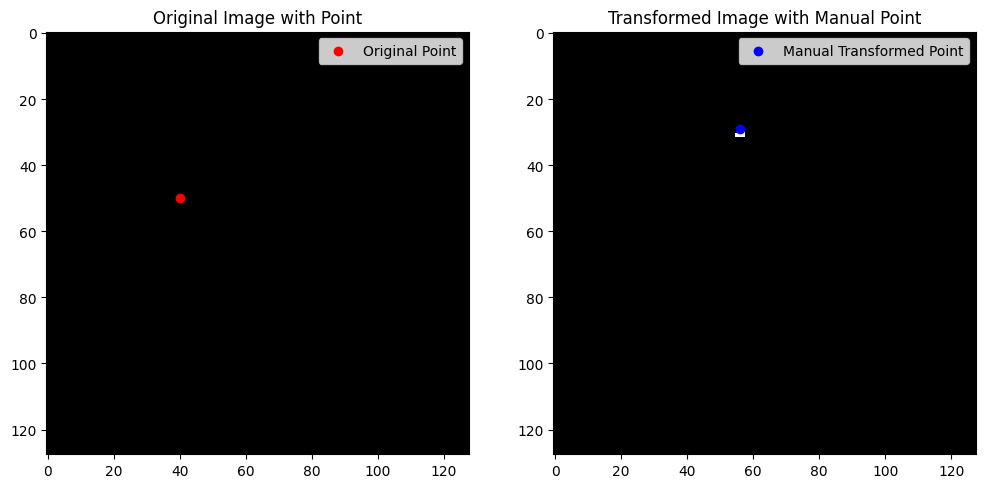

Manual Point Coordinates: (56.430780618346944, 29.751288694035736)
Pixel Value at Manual Point: 0.0


In [9]:
import torch
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# Example: Original point and affine parameters
image = torch.zeros(1, 1, 128, 128)  # Blank image for simplicity
original_point = (40, 50)            # The point to track
image[:, :, original_point[1], original_point[0]] = 1  # Mark the point on the image

# Transformation parameters
center = (64, 64)  # Center of transformation
angle = 30         # Rotation angle in degrees
translate = (20, 14)  # Translation in x and y
scale = 2         # Scaling factor
shear = (0, 0)     # Shear angles

# Step 1: Transform the image using TF.affine
transformed_image = TF.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)

# Step 2: Manually calculate the transformed coordinates
manual_point = get_affine_transformed_coordinates(
    point=original_point,
    center=center,
    angle=angle,
    translate=translate,
    scale=scale,
    shear=shear
)

# Step 3: Locate the pixel at the manually transformed position
manual_x, manual_y = map(int, manual_point)
if 0 <= manual_x < transformed_image.shape[3] and 0 <= manual_y < transformed_image.shape[2]:
    manual_pixel_value = transformed_image[0, 0, manual_y, manual_x].item()
else:
    manual_pixel_value = None  # Out-of-bounds case

# Step 4: Visualize and compare
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image with Point")
plt.imshow(image.squeeze(0).squeeze(0), cmap="gray")
plt.scatter([original_point[0]], [original_point[1]], color="red", label="Original Point")
plt.legend()

# Transformed image
plt.subplot(1, 2, 2)
plt.title("Transformed Image with Manual Point")
plt.imshow(transformed_image.squeeze(0).squeeze(0), cmap="gray")
plt.scatter([manual_x], [manual_y], color="blue", label="Manual Transformed Point")
plt.legend()

plt.show()

# Step 5: Compare the manual and ground truth
print(f"Manual Point Coordinates: {manual_point}")
print(f"Pixel Value at Manual Point: {manual_pixel_value}")

# Optional: Calculate Euclidean distance between manual and observed position


In [10]:
import sys
print(sys.version) 

3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]


#### Moving MNIST dataset

In [11]:
import sys
import os

# Add the directory containing the module to the Python path
sys.path.append('/gpfs/helios/home/ploter/projects/MovingMNIST/torch_moving_mnist')

from functools import partial
from types import SimpleNamespace
from torch.utils.data import Dataset
from torchvision.datasets import MNIST

# %% ../nbs/01_data.ipynb 10
import random

import torch
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from torch_moving_mnist.data import *

# %% ../nbs/01_data.ipynb 34
import math
import random
from fastprogress import progress_bar

import copy

# def apply_n_times(tf, tcf, x, y, n=1):
#     sequence = [x]
#     sequence_y = [(round(y[0]), round(y[1]))]

#     for n in range(n):
#         sequence.append(tf(sequence[n]))

#         x1, y1 = tcf(sequence_y[n])
#         sequence_y.append(
#             (round(x1), round(y1))
#         )

#     return sequence, sequence_y

# class RandomTrajectory:
#     def __init__(self, affine_params, center, n=5, **kwargs):
#         self.angle     = random.uniform(*affine_params.angle)
#         self.translate = (random.uniform(*affine_params.translate[0]),
#                           random.uniform(*affine_params.translate[1]))
#         self.scale     = random.uniform(*affine_params.scale)
#         self.shear     = random.uniform(*affine_params.shear)
#         self.n = n
#         self.center = center
#         self.tf = partial(TF.affine, angle=self.angle, translate=self.translate, scale=self.scale, shear=self.shear, **kwargs)
#         self.tcf = partial(
#             get_affine_transformed_coordinates,
#             angle=self.angle,
#             translate=self.translate,
#             scale=self.scale,
#             shear=self.shear,
#             center=self.center
#         )

#     def __call__(self, img, target):
#         return apply_n_times(self.tf, self.tcf, img, target, n=self.n)

#     def __repr__(self):
#         s = ("RandomTrajectory(\n"
#              f"  angle:     {self.angle}\n"
#              f"  translate: {self.translate}\n"
#              f"  scale:     {self.scale}\n"
#              f"  shear:     {self.shear}\n)")
#         return s

def check_boundary_collision(point, next_point, img_size, digit_size=28, use_center=True):
    """
    Check if digit hits boundary or would cross it in next step.
    Returns collision flags and adjusted next position.
    Args:
        point: Current (x, y) coordinates
        next_point: Next predicted (x, y) coordinates
        img_size: Size of the frame
        digit_size: Size of the MNIST digit (default 28)
        use_center: If True, bounce when center hits boundary. If False, bounce when digit boundary hits
    """
    x, y = point
    next_x, next_y = next_point
    half_digit = digit_size // 2
    # Determine boundaries based on configuration
    if use_center:
        min_bound = 0
        max_bound = img_size
    else:
        min_bound = half_digit
        max_bound = img_size - half_digit
    # Check if next position would cross boundary and adjust it
    if next_x <= min_bound:
        next_x = min_bound + (min_bound - next_x)
        collision_x = True
    elif next_x >= max_bound:
        next_x = max_bound - (next_x - max_bound)
        collision_x = True
    else:
        collision_x = False
    if next_y <= min_bound:
        next_y = min_bound + (min_bound - next_y)
        collision_y = True
    elif next_y >= max_bound:
        next_y = max_bound - (next_y - max_bound)
        collision_y = True
    else:
        collision_y = False
    return collision_x, collision_y, (next_x, next_y)

def reflect_trajectory(translate, collision_x, collision_y):
    """Reflect trajectory based on collision"""
    tx, ty = translate
    if collision_x:
        tx = -tx
    if collision_y:
        ty = -ty
    return (tx, ty)

class RandomTrajectory:
    def __init__(self, affine_params, center, n=5, bounce=True, use_center_bounce=True, **kwargs):
        self.angle = random.uniform(*affine_params.angle)
        self.translate = (random.uniform(*affine_params.translate[0]),
                         random.uniform(*affine_params.translate[1]))
        self.scale = random.uniform(*affine_params.scale)
        self.shear = random.uniform(*affine_params.shear)
        self.n = n
        self.center = center
        self.bounce = bounce
        self.use_center_bounce = use_center_bounce
        self.img_size = center[0] * 2  # Assuming square image
        self.tf = partial(TF.affine, angle=self.angle, translate=self.translate, 
                         scale=self.scale, shear=self.shear, **kwargs)
        self.tcf = partial(
            get_affine_transformed_coordinates,
            angle=self.angle,
            translate=self.translate,
            scale=self.scale,
            shear=self.shear,
            center=self.center
        )
    def __call__(self, img, target):
        sequence = [img]
        sequence_y = [(round(target[0]), round(target[1]))]
        current_translate = self.translate
        for _ in range(self.n):
            # Calculate next position before applying transformation
            if self.bounce:
                # Get next position without actually moving
                next_tcf = partial(
                    get_affine_transformed_coordinates,
                    angle=self.angle,
                    translate=current_translate,
                    scale=self.scale,
                    shear=self.shear,
                    center=self.center
                )
                next_x, next_y = next_tcf(sequence_y[-1])
                # Check for boundary collision and get adjusted position
                collision_x, collision_y, adjusted_next_pos = check_boundary_collision(
                    sequence_y[-1],
                    (next_x, next_y),
                    self.img_size,
                    use_center=self.use_center_bounce
                )
                if collision_x or collision_y:
                    # Update translation for next frame
                    current_translate = reflect_trajectory(
                        current_translate, collision_x, collision_y
                    )
                    # Calculate transformation to reach adjusted position
                    dx = adjusted_next_pos[0] - sequence_y[-1][0]
                    dy = adjusted_next_pos[1] - sequence_y[-1][1]
                    current_translate = (dx, dy)
            # Apply transformation with potentially adjusted translation
            tf = partial(TF.affine, angle=self.angle, translate=current_translate,
                        scale=self.scale, shear=self.shear)
            tcf = partial(
                get_affine_transformed_coordinates,
                angle=self.angle,
                translate=current_translate,
                scale=self.scale,
                shear=self.shear,
                center=self.center
            )
            sequence.append(tf(sequence[-1]))
            x1, y1 = tcf(sequence_y[-1])
            sequence_y.append((round(x1), round(y1)))
        return sequence, sequence_y


class MovingMNIST(Dataset):
    def __init__(self, path=".",  # path to store the MNIST dataset
                 affine_params: dict=affine_params, # affine transform parameters, refer to torchvision.transforms.functional.affine
                 num_digits: list[int]=[1,2], # how many digits to move, random choice between the value provided
                 num_frames: int=4, # how many frames to create
                 img_size=64, # the canvas size, the actual digits are always 28x28
                 concat=True, # if we concat the final results (frames, 1, 28, 28) or a list of frames.
                 normalize=False, # scale images in [0,1] and normalize them with MNIST stats. Applied at batch level. Have to take care of the canvas size that messes up the stats!
                 bounce=True,  # Enable/disable bouncing
                 use_center_bounce=True,  # Use center or boundary for bounce detection
                 frame_dropout_pattern = None,
                 sequences_path = None, #TODO: REMOVE
                 split_indices=None,
                 sampler_steps=[], # epochs at which assign coresponding frame dropout probability
                 frame_dropout_probs=[], # absolut frame drop probability values
                 ):
        self.bounce = bounce
        self.use_center_bounce = use_center_bounce
        self.sequences = None
        if sequences_path is not None:
          data = torch.load(sequences_path)
          self.sequences = list(zip(data['imgs'], data['targets']))

          num_frames = self.sequences[0][0].shape[0]
          img_size = self.sequences[0][0].shape[2]
          print(f'Num frames: {num_frames}')
          print(f'Img size: {img_size}')

        self.num_digits = num_digits
        if self.sequences is None:
          mnist = MNIST(path, download=True)
          self.mnist_dataset = mnist.data
          self.mnist_targets = mnist.targets

          if split_indices is not None:
            self.mnist_dataset = self.mnist_dataset[split_indices]
            self.mnist_targets = self.mnist_targets[split_indices]
          self.ids = [[random.randrange(0, len(self.mnist_dataset)) for _ in range(random.choice(self.num_digits))] for _ in range(len(self.mnist_dataset))]
          self.affine_params = affine_params

        self.num_frames = num_frames
        self.img_size = img_size
        self.pad = padding(img_size)
        self.concat = concat

        self.keep_frame_mask = None
        self.frame_dropout_prob = 0.0
        
        self.sampler_steps = sampler_steps
        self.frame_dropout_probs = frame_dropout_probs
        print("sampler_steps={} frame_dropout_probs={}".format(self.sampler_steps, self.frame_dropout_probs))
        
        if self.sampler_steps is not None and len(self.sampler_steps) > 0:
            # Enable sampling length adjustment.
            assert len(self.frame_dropout_probs) > 0
            assert len(self.frame_dropout_probs) == len(self.sampler_steps) + 1
            for i in range(len(self.sampler_steps) - 1):
                assert self.sampler_steps[i] < self.sampler_steps[i + 1]
            self.period_idx = 0
            self.frame_dropout_prob = self.frame_dropout_probs[0]
            self.current_epoch = 0

        if frame_dropout_pattern is not None:
          print('Disable probability based frame drops. Use frame drops based on fixed mask.')
          self.frame_dropout_prob = None
          self.sampler_steps = []
          drop_frame_mask = torch.tensor([int(char) for char in frame_dropout_pattern])
          self.keep_frame_mask = 1 - drop_frame_mask
          assert self.keep_frame_mask.size(0) == self.num_frames, f"Frame dropout pattern must have the same length as the number of frames. Num of frames {self.num_frames} and mask size {self.keep_frame_mask.size(0)}"
          print(f'Set frame keep mask: {self.keep_frame_mask}')

        # some computation to ensure normalizing correctly-ish
        batch_tfms = [T.ConvertImageDtype(torch.float32)]
        if normalize:
            ratio = (28/img_size)**2*max(num_digits)
            mean, std = mnist_stats
            scaled_mnist_stats = ([mean[0]*ratio], [std[0]*ratio])
            print(f"New computed stats for MovingMNIST: {scaled_mnist_stats}")
            batch_tfms += [T.Normalize(*scaled_mnist_stats)] if normalize else []
        self.batch_tfms = T.Compose(batch_tfms)


    def set_epoch(self, epoch):
        self.current_epoch = epoch
        if self.frame_dropout_probs is None or len(self.frame_dropout_probs) == 0:
            return

        for i in range(len(self.sampler_steps)):
            if epoch >= self.sampler_steps[i]:
                self.period_idx = i + 1
        print("set epoch: epoch {} period_idx={}".format(epoch, self.period_idx))
        self.frame_dropout_prob = self.frame_dropout_probs[self.period_idx]

    def step_epoch(self):
        # one epoch finishes.
        print("Dataset: epoch {} finishes".format(self.current_epoch))
        self.set_epoch(self.current_epoch + 1)
    
    def random_place(self, img):
        "Randomly place the digit inside the canvas"
        x = random.uniform(-self.pad, self.pad)
        y = random.uniform(-self.pad, self.pad)

        center_point = get_affine_transformed_coordinates(
            (self.img_size//2, self.img_size//2),
            translate=(x,y),
            center=(self.img_size//2, self.img_size//2),
        )
        return TF.affine(img, translate=(x,y), angle=0, scale=1, shear=(0,0)), center_point

    def get_digit(self, digit_idx):
        "Get a MNIST digit randomly placed on the canvas"
        img = self.mnist_dataset[[digit_idx]]
        pimg = TF.pad(img, padding=self.pad)
        img, center_point = self.random_place(pimg)
        target = {
            'label': int(self.mnist_targets[digit_idx]),
            'center_point': center_point
        }
        return img, target

    def _one_moving_digit(self, id):
        digit, target = self.get_digit(digit_idx=id)
        traj = RandomTrajectory(
            self.affine_params, center=(self.img_size//2, self.img_size//2), 
            n=self.num_frames-1,
            bounce=self.bounce,
            use_center_bounce=self.use_center_bounce,
        )
        sequence, points = traj(digit, target['center_point'])

        targets = []
        for point in points:
            targets.append({
                'label': target['label'],
                'center_point': point
            })

        return torch.stack(sequence), targets

    def generate_sequence(self, idx):
      moving_digits_and_targets = [self._one_moving_digit(id) for id in self.ids[idx]]
      moving_digits = torch.stack([d[0] for d in moving_digits_and_targets])

      combined_digits = moving_digits.max(dim=0)[0]
      targets = []

      for frame_number in range(self.num_frames):
          target = {}

          labels = []
          center_points = []

          for i in range(len(self.ids[idx])):
              digit_target = moving_digits_and_targets[i][1][frame_number]

              if 'label' in digit_target and digit_target['center_point'][0] >= 0 and digit_target['center_point'][1] >= 0 and digit_target['center_point'][0] < self.img_size and digit_target['center_point'][1] < self.img_size:
                labels.append(digit_target['label'])
                center_points.append(digit_target['center_point'])

          target['labels'] = torch.tensor(labels, dtype=torch.int64)
          target['center_points'] = torch.tensor(center_points, dtype=torch.float32)
          targets.append(target)

      return combined_digits, targets


    def __getitem__(self, idx):
      if self.sequences is None:
        images, targets = self.generate_sequence(idx)
      else:
        images, targets = self.sequences[idx]

      targets = copy.deepcopy(targets) # targets dictionary is mutable

      if self.keep_frame_mask is not None:
        keep_frame_flags = self.keep_frame_mask
      else:
        num_potential_drop_frames = self.num_frames // 2
        frame_keep_probs = torch.rand(num_potential_drop_frames)
        keep_frame_flags = (frame_keep_probs > self.frame_dropout_prob).int()
        keep_frame_flags = torch.cat([torch.ones(self.num_frames - num_potential_drop_frames), keep_frame_flags])

      for frame_number, (img, target) in enumerate(zip(images, targets)):
        if target['center_points'].size(0) > 0:
          target['center_points'] /= torch.tensor([self.img_size, self.img_size], dtype=torch.float32)

          target['labels'] = target['labels'].to(torch.int64)

        target['keep_frame'] = keep_frame_flags[frame_number]
        target['orig_size'] = torch.as_tensor([int(self.img_size), int(self.img_size)])

      images = self.batch_tfms(images)

      return images, targets

    def __len__(self):
        if self.sequences is None:
          return len(self.ids)
        else:
          return len(self.sequences)

    def save(self, fname="mmnist.pt"):
        data_imgs = []
        data_targets = []
        for i in progress_bar(range(len(self.ids))):
            imgs, targets = self.generate_sequence(i)
            data_imgs.append(imgs)

            data_targets.append(targets)

        print("Saving dataset")
        torch.save(
            {
                'imgs': torch.stack(data_imgs),
                'targets': data_targets,
            },
            f"{fname}"
            )

#### Builder

In [12]:
import os
import pickle


def build_dataset(split, args, frame_dropout_pattern=None):

    dataset_name = args.dataset.lower()
    assert dataset_name.startswith('moving-mnist')

    if '1digit' in dataset_name:
        num_digits = [1]
    elif '2digit' in dataset_name:
        num_digits = [2]
    else:
        raise ValueError(f'unknown {dataset_name}')

    split_indices_attr = f"{split}_split_indices"

    if not hasattr(args, split_indices_attr) or getattr(args, f"{split}_split_indices") == None or len(getattr(args, f"{split}_split_indices")) == 0:
        # Load the MNIST dataset only once
        full_dataset = MNIST(".", download=True)
        num_samples = len(full_dataset)
        
        # Create train and validation indices
        indices = list(range(num_samples))
        indices_split = int(args.train_val_split_ratio * num_samples)
        np.random.shuffle(indices)
        
        train_indices = indices[:indices_split]
        val_indices = indices[indices_split:]
        if args.debug:
          downsample_factor = 0.005
          print(f'Downsample factor: {downsample_factor}')
          val_indices = val_indices[:int(len(val_indices) * downsample_factor)]
          train_indices = train_indices[:int(len(train_indices) * downsample_factor)]

        args.train_split_indices = train_indices
        args.val_split_indices = val_indices

    
    split_indices = getattr(args, f"{split}_split_indices")    

    affine_params = SimpleNamespace(
      angle=(0, 0),
      translate=((-5, 5), (-5, 5)),
      scale=(1, 1),
      shear=(0, 0),
    )
    bounce = False
    use_center_bounce = False
    if split == 'train':
        dataset = MovingMNIST(
            normalize=True,
            bounce=bounce,
            use_center_bounce=use_center_bounce,
            num_digits=num_digits,
            num_frames=args.num_frames,
            split_indices=split_indices,
            frame_dropout_probs=args.frame_dropout_probs,
            sampler_steps=args.sampler_steps,
            affine_params=affine_params,
        )
    elif split == 'val':
        dataset = MovingMNIST(
            normalize=True,
            bounce=bounce,
            use_center_bounce=use_center_bounce,
            num_digits=num_digits,
            num_frames=args.num_frames,
            split_indices=split_indices,
            frame_dropout_pattern=frame_dropout_pattern,
            affine_params=affine_params,
        )
    else:
        raise ValueError(f'unknown {split}')

    return dataset

In [13]:
def collate_fn(batch):
    batch = list(zip(*batch))
    batch[0] = torch.stack(batch[0])
    batch[1] = list(batch[1])
    return tuple(batch)

### Criterion

In [14]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
Modules to compute the matching cost and solve the corresponding LSAP.
"""
import numpy as np
import torch
from scipy.optimize import linear_sum_assignment
from torch import nn


class HungarianMatcher(nn.Module):
    """This class computes an assignment between the targets and the predictions of the network

    For efficiency reasons, the targets don't include the no_object. Because of this, in general,
    there are more predictions than targets. In this case, we do a 1-to-1 matching of the best
    predictions, while the others are un-matched (and thus treated as non-objects).
    """

    def __init__(self, cost_class: float = 1, cost_center_point: float = 1,
                 focal_alpha: float = 0.25, focal_gamma: float = 2.0):
        """Creates the matcher

        Params:
            cost_class: This is the relative weight of the classification error in the matching cost
            cost_bbox: This is the relative weight of the L1 error of the bounding box coordinates
                       in the matching cost
            cost_giou: This is the relative weight of the giou loss of the bounding box in the
                       matching cost
        """
        super().__init__()
        self.cost_class = cost_class

        self.cost_center_point = cost_center_point

        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma

        assert cost_class != 0 or cost_center_point != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):

        batch_size, num_queries = outputs["pred_logits"].shape[:2]

        # There're 2 cases for this clss
        # 1. w/o temporal dimention:
        # batch size dimention represents number of independent frames in the batch
        # 2. w/ temporal dimention:
        # batch size dimention represents number of frames in the sequence
        # (we do not support multiple sequences in the batch)

        # We flatten to compute the cost matrices in a batch
        #
        # [batch_size * num_queries, num_classes]
        out_prob = outputs["pred_logits"].flatten(0, 1).sigmoid()

        # [batch_size * num_queries, 2]
        out_center_points = outputs["pred_center_points"].flatten(0, 1)

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])

        tgt_center_points = torch.cat([v["center_points"] for v in targets])

        # Compute the classification cost.
        neg_cost_class = (1 - self.focal_alpha) * (out_prob ** self.focal_gamma) * (-(1 - out_prob + 1e-8).log())
        pos_cost_class = self.focal_alpha * ((1 - out_prob) ** self.focal_gamma) * (-(out_prob + 1e-8).log())

        # tgt_ids - concatenated GT label ids
        # Per each query we contains logits per all labes
        # [batch_size * num_queries, batch_size]
        cost_class = pos_cost_class[:, tgt_ids] - neg_cost_class[:, tgt_ids]

        # Compute the L1 cost between center points
        cost_center_points = torch.cdist(out_center_points, tgt_center_points, p=1)

        # Final cost matrix
        # [batch_size * num_queries, batch_size]
        cost_matrix = self.cost_class * cost_class \
              + self.cost_center_point * cost_center_points

        # [batch_size, num_queries, batch_size]
        cost_matrix = cost_matrix.view(batch_size, num_queries, -1).cpu()

        # Number of GTs per each batch index
        # [batch_size]
        sizes = [len(v["labels"]) for v in targets] # Changed from targets to labels

        # Split returns a tuple where each element has hape [batch_size, num_queries, size]
        # During enumeration we assign particular batch index between query and GT size
        indices = [linear_sum_assignment(c[i])
                   for i, c in enumerate(cost_matrix.split(sizes, -1))]

        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64))
                for i, j in indices]


def build_matcher():
    return HungarianMatcher(
        cost_class = 2, 
        cost_center_point = 5,
    )


In [15]:
# b = torch.tensor([1, 1, 1, 1, 1, 1, 1, 3]) # sizes
# a = torch.arange(0, 8*4*b.sum().item()).reshape(8, 4, -1)
# _split = a.split(b.tolist(),-1)
# indices = [linear_sum_assignment(c[i])
#             for i, c in enumerate(a.split(b.tolist(),-1))]

In [16]:
import torch
import torch.nn as nn
from scipy.optimize import linear_sum_assignment

class SetCriterion(nn.Module):
    def __init__(self, num_classes, matcher, focal_alpha, focal_gamma, weight_dict):
        super(SetCriterion, self).__init__()
        self.num_classes = num_classes
        self.coord_criterion = nn.MSELoss(reduction='sum')
        self.class_criterion = nn.CrossEntropyLoss(reduction='sum')
        self.matcher = matcher
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma
        self.weight_dict = weight_dict

    def loss_labels_focal(self, outputs, targets, indices, num_objects, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs

        # [batch_size, number_queries, number_of_classes]
        src_logits = outputs['pred_logits']

        # (batch_ids, output_query_ids)
        idx = self._get_src_permutation_idx(indices)

        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])

        # [batch_size, number_queries]
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)

        target_classes[idx] = target_classes_o

        # [batch_size, number_queries, number_of_classes+1]
        target_classes_onehot = torch.zeros([src_logits.shape[0], src_logits.shape[1], src_logits.shape[2] + 1],
                                            dtype=src_logits.dtype, layout=src_logits.layout, device=src_logits.device)

        #
        target_classes_onehot.scatter_(2, target_classes.unsqueeze(-1), 1)

        # [batch_size, number_queries, number_of_classes]
        target_classes_onehot = target_classes_onehot[:,:,:-1]

        loss_ce = sigmoid_focal_loss(
            src_logits, target_classes_onehot, num_objects,
            alpha=self.focal_alpha, gamma=self.focal_gamma)

        loss_ce *= src_logits.shape[1] # Why?
        losses = {'loss_ce': loss_ce}

        if log:
            # TODO this should probably be a separate loss, not hacked in this one here
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]

        return losses

    def loss_center_points(self, outputs, targets, indices, num_objects, log=True):
        """L1 center point loss
        targets dicts must contain the key "center_points" containing a tensor of dim [nb_target_boxes, 2]
        """
        assert 'pred_center_points' in outputs

        idx = self._get_src_permutation_idx(indices)
        src_cps = outputs['pred_center_points'][idx]
        target_cps = torch.cat([t['center_points'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_cp = F.l1_loss(src_cps, target_cps, reduction='none')

        losses = {}
        losses['loss_center_point'] = loss_cp.sum() / num_objects

        return losses

    def forward(self, outputs, targets):
        indecies = self.matcher(outputs, targets)

        num_objects = sum(len(t["labels"]) for t in targets)
        num_objects = torch.as_tensor(
            [num_objects], dtype=torch.float, device=next(iter(outputs.values())).device)

        losses = {}
        loss_labels = self.loss_labels_focal(outputs, targets, indecies, num_objects)
        loss_center_points = self.loss_center_points(outputs, targets, indecies, num_objects)

        losses.update(loss_labels)
        losses.update(loss_center_points)
        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

def build_criterion(num_classes):
    matcher = build_matcher()
    return SetCriterion(
        num_classes,
        matcher,
        focal_alpha=0.25,
        focal_gamma=2,
        weight_dict={
            'loss_ce': 2,
            'loss_center_point': 5
        }
    )

In [17]:
def sigmoid_focal_loss(inputs, targets, num_boxes, alpha: float = 0.25, gamma: float = 2, query_mask=None, reduction=True):
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
    Returns:
        Loss tensor
    """
    prob = inputs.sigmoid()
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if not reduction:
        return loss

    if query_mask is not None:
        loss = torch.stack([l[m].mean(0) for l, m in zip(loss, query_mask)])
        return loss.sum() / num_boxes
    return loss.mean(1).sum() / num_boxes

In [18]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    if target.numel() == 0:
        return [torch.zeros([], device=output.device)]
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

### Postprocessors

In [19]:
import matplotlib.pyplot as plt

class AverageDisplacementErrorEvaluator:

    def __init__(self, matcher, output_dir, prefix='', img_size = 1):
        self.matcher = matcher  # Matcher for finding the best target for each prediction
        self.ADE = []  # List to store displacement errors
        self.prefix = prefix  # Prefix for summary keys
        self.result = None  # Placeholder for accumulated result
        self.output_dir = output_dir
        self.img_size = img_size

    def update(self, outputs, targets):
        """
        Updates the evaluator with outputs and targets by computing the displacement errors.

        Parameters:
        outputs (dict): Dictionary containing the model's predicted outputs.
        targets (list): List of dictionaries containing the ground-truth target data.
        """
        # Match predictions to targets
        indices = self.matcher(outputs, targets)

        # Permute predictions based on matched indices
        idx = self._get_src_permutation_idx(indices)
        src_cps = outputs['pred_center_points'][idx] # Predicted center points
        src_cps *= torch.tensor([self.img_size, self.img_size], dtype=torch.float32)
        
        target_cps = torch.cat([t['center_points'][i] for t, (_, i) in zip(targets, indices)], dim=0)  # True center points
        target_cps *= torch.tensor([self.img_size, self.img_size], dtype=torch.float32)

        displacements = torch.norm(src_cps - target_cps, dim=1).detach().cpu()  # Shape: [N, 1]

        batch_idx, _ = idx

        for i in range(len(batch_idx)):
            idx = batch_idx[i].item()
            
            if len(self.ADE) == idx:
                # no list for the timestamp (or batch id)
                self.ADE.append([])
            
            assert self.ADE[idx] is not None, "List for the batch index should exist"
            self.ADE[idx].append(displacements[i].item())

    def accumulate(self):
        """
        Computes the final accumulated result by averaging all stored errors.
        """
        self.result = []
        for displacements_per_timestamp in self.ADE:
            mean = float(np.mean(displacements_per_timestamp))
            self.result.append(mean)

    def summary(self):
        """
        Returns a summary of the results.

        Returns:
        dict: Dictionary containing the ADE result with the prefix as a key.
        """
        timestamps = list(range(len(self.result))) 
        plt.figure(figsize=(8, 5))
        plt.plot(timestamps, self.result, marker='o', label='ADE')
        plt.title(f'ADE vs. Timestamp{" (" + self.prefix + ")" if self.prefix else ""}')
        plt.xlabel('Timestamp')
        plt.ylabel('ADE')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        # Save the plot
        plt.savefig(self.output_dir)
        plt.close()

        return {f'{self.prefix+"_" if self.prefix else ""}ADE_{t}': ade for t, ade in enumerate(self.result)}

    def _get_src_permutation_idx(self, indices):
      # permute predictions following indices
      batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
      src_idx = torch.cat([src for (src, _) in indices])
      return batch_idx, src_idx


class PostProcessTrajectory(nn.Module):

    def __init__(self):
        super().__init__()

    @torch.no_grad()
    def forward(self, outputs, targets):
        outputs = {
            k: v.detach().cpu() for k, v in outputs.items()
        }

        targets = [{k: v.detach().cpu() for k, v in t.items()} for t in targets]
        
        return outputs, targets


### Engine

#### Train

In [20]:
from tqdm import tqdm
import torchmetrics
from collections import defaultdict

def train_one_epoch(model, dataloader, optimizer, criterion, epoch, device):
    model.train()
    metric_logger = defaultdict(lambda: torchmetrics.MeanMetric().to(device))

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=True)

    print_freq = 50

    for i, (samples, targets) in enumerate(progress_bar):
        samples = samples.to(device)

        targets = [[{k: v.to(device) for k, v in t.items()} for t in batch_targets] for batch_targets in targets]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        out, targets_flat = model(samples, targets)
        loss_dict = criterion(out, targets_flat)

        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # Logic related to reduce
        loss_dict_unscaled = {
            f'{k}_unscaled': v for k, v in loss_dict.items()}
        loss_dict_scaled = {
            k: v * weight_dict[k] for k, v in loss_dict.items() if k in weight_dict}
        losses_scaled = sum(loss_dict_scaled.values())

        loss_value = losses_scaled.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        # Backpropagation and optimization
        losses.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
        optimizer.step()

        # Update metric logger with main loss and each component
        metric_logger['loss'].update(loss_value)
        metric_logger["class_error"].update(loss_dict['class_error'].item())

        for k, v in loss_dict_unscaled.items():
            metric_logger[k].update(v.item())
        for k, v in loss_dict_scaled.items():
            metric_logger[k].update(v.item())

        if i % print_freq == 0 or i == len(dataloader) - 1:
            progress_bar.set_postfix({
                **{k: metric.compute().item() for k, metric in metric_logger.items()},
                "lr": optimizer.param_groups[0]["lr"],
                'frame_dropout_prob': dataloader.dataset.frame_dropout_prob,
            })

    avg_values = {k: metric.compute().item() for k, metric in metric_logger.items()}

    for metric in metric_logger.values():
      metric.reset()

    return avg_values

#### Eval

In [21]:
from tqdm import tqdm

def evaluate(model, dataloader, criterion, postprocessors, epoch, device, output_dir, experiment='default'):

    average_displacement_error_evaluator = None
    if 'trajectory' in postprocessors:
      average_displacement_error_evaluator = AverageDisplacementErrorEvaluator(
          output_dir=f'{output_dir}/ade_{experiment}_epoch-{epoch}.png',
          prefix=experiment,
          matcher=criterion.matcher,
          img_size=dataloader.dataset.img_size,
        )

    model.eval()

    print_freq = 50

    metric_logger = defaultdict(lambda: torchmetrics.MeanMetric().to(device))

    # Disabling gradient calculation for evaluation
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc=f"Eval {epoch}:", leave=True)

        for i, (samples, targets) in enumerate(progress_bar):
            samples = samples.to(device)
            targets = [[{k: v.to(device) for k, v in t.items()} for t in batch_targets] for batch_targets in targets]

            # Forward pass
            out, targets_flat = model(samples, targets)

            loss_dict = criterion(out, targets_flat)

            weight_dict = criterion.weight_dict
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            # Logic related to reduce
            loss_dict_unscaled = {
                f'{k}_unscaled': v for k, v in loss_dict.items()}
            loss_dict_scaled = {
                k: v * weight_dict[k] for k, v in loss_dict.items() if k in weight_dict}
            losses_scaled = sum(loss_dict_scaled.values())

            loss_value = losses_scaled.item()

            metric_logger['loss'].update(loss_value)
            metric_logger['class_error'].update(loss_dict['class_error'].item())

            for k, v in loss_dict_unscaled.items():
              metric_logger[k].update(v.item())
            for k, v in loss_dict_scaled.items():
              metric_logger[k].update(v.item())

            if i % print_freq == 0 or i == len(dataloader) - 1:
              progress_bar.set_postfix({
                  **{k: metric.compute().item() for k, metric in metric_logger.items()},
                  'frame_dropout_prob': dataloader.dataset.frame_dropout_prob,
              })

            if average_displacement_error_evaluator:
              average_displacement_error_evaluator.update(*postprocessors['trajectory'](out, targets_flat))

    avg_values = {k: metric.compute().item() for k, metric in metric_logger.items()}

    if average_displacement_error_evaluator:
      average_displacement_error_evaluator.accumulate()
      avg_values.update(average_displacement_error_evaluator.summary())

    for metric in metric_logger.values():
      metric.reset()

    return avg_values


### Generate dataset

In [22]:
import os

train_suffix = '_train'
val_suffix = '_val'
extension = '.pt'

dataset_dir = f'/gpfs/helios/home/ploter/projects/datasets/moving-mnist/'

if not os.path.exists(dataset_dir):
  os.makedirs(dataset_dir)

dataset_name_1d_tr = 'moving-mnist-1digit-tr'
dataset_name_2d_tr = 'moving-mnist-2digit-tr'

if not os.path.exists(os.path.join(dataset_dir, dataset_name_1d_tr+train_suffix+extension)):
  print(f'Generating datasets {dataset_name_1d_tr}')

  train_val_split_ratio = 0.8
  # Load the MNIST dataset to get the total number of samples
  full_dataset = MNIST(".", download=True)
  num_samples = len(full_dataset)

  # Generate train and validation indices
  indices = list(range(num_samples))
  split_index = int(train_val_split_ratio * num_samples)
  np.random.shuffle(indices)

  train_indices = indices[:split_index]
  val_indices = indices[split_index:]

  affine_params = SimpleNamespace(
      angle=(0, 0),
      translate=((-5, 5), (-5, 5)),
      scale=(1, 1),
      shear=(0, 0),
  )
  number_frames = 8
  num_digits = [1]
  img_size = 64

  dataset_train = MovingMNIST(
      affine_params=affine_params, num_frames=number_frames, num_digits=num_digits, img_size=img_size,
      normalize=False,
      split_indices=train_indices,
      )

  dataset_train.save(fname=os.path.join(dataset_dir, dataset_name_1d_tr+train_suffix+extension))

  dataset_val = MovingMNIST(
      affine_params=affine_params, num_frames=number_frames, num_digits=num_digits, img_size=img_size,
      normalize=False,
      split_indices=val_indices,
      )

  dataset_val.save(fname=os.path.join(dataset_dir, dataset_name_1d_tr+val_suffix+extension))

  downsample_factor = 0.005
  print(f'Downsample factor: {downsample_factor}')
  val_indices = val_indices[:int(len(val_indices) * downsample_factor)]
  train_indices = train_indices[:int(len(train_indices) * downsample_factor)]

  dataset_train = MovingMNIST(
      affine_params=affine_params, num_frames=number_frames, num_digits=num_digits, img_size=img_size,
      normalize=False,
      split_indices=train_indices,
      )

  dataset_train.save(fname=os.path.join(dataset_dir, dataset_name_1d_tr+'_debug'+train_suffix+extension))

  dataset_val = MovingMNIST(
      affine_params=affine_params, num_frames=number_frames, num_digits=num_digits, img_size=img_size,
      normalize=False,
      split_indices=val_indices,
      )

  dataset_val.save(fname=os.path.join(dataset_dir, dataset_name_1d_tr+'_debug'+val_suffix+extension))


if not os.path.exists(os.path.join(dataset_dir, dataset_name_2d_tr+train_suffix+extension)):
  print(f'Generating datasets {dataset_name_2d_tr}')

  train_val_split_ratio = 0.8
  # Load the MNIST dataset to get the total number of samples
  full_dataset = MNIST(".", download=True)
  num_samples = len(full_dataset)

  # Generate train and validation indices
  indices = list(range(num_samples))
  split_index = int(train_val_split_ratio * num_samples)
  np.random.shuffle(indices)

  train_indices = indices[:split_index]
  val_indices = indices[split_index:]

  affine_params = SimpleNamespace(
      angle=(0, 0),
      translate=((-5, 5), (-5, 5)),
      scale=(1, 1),
      shear=(0, 0),
  )
  number_frames = 8
  num_digits = [2]
  img_size = 64

  dataset_train = MovingMNIST(
      affine_params=affine_params, num_frames=number_frames, num_digits=num_digits, img_size=img_size,
      normalize=False,
      split_indices=train_indices,
      )

  dataset_train.save(fname=os.path.join(dataset_dir, dataset_name_2d_tr+train_suffix+extension))

  dataset_val = MovingMNIST(
      affine_params=affine_params, num_frames=number_frames, num_digits=num_digits, img_size=img_size,
      normalize=False,
      split_indices=val_indices,
      )

  dataset_val.save(fname=os.path.join(dataset_dir, dataset_name_2d_tr+val_suffix+extension))

  downsample_factor = 0.005
  print(f'Downsample factor: {downsample_factor}')
  val_indices = val_indices[:int(len(val_indices) * downsample_factor)]
  train_indices = train_indices[:int(len(train_indices) * downsample_factor)]

  dataset_train = MovingMNIST(
      affine_params=affine_params, num_frames=number_frames, num_digits=num_digits, img_size=img_size,
      normalize=False,
      split_indices=train_indices,
      )

  dataset_train.save(fname=os.path.join(dataset_dir, dataset_name_2d_tr+'_debug'+train_suffix+extension))

  dataset_val = MovingMNIST(
      affine_params=affine_params, num_frames=number_frames, num_digits=num_digits, img_size=img_size,
      normalize=False,
      split_indices=val_indices,
      )

  dataset_val.save(fname=os.path.join(dataset_dir, dataset_name_2d_tr+'_debug'+val_suffix+extension))

### Main

#### Args

In [23]:
class Args:
    def __init__(self):
        self.seed = 42
        self.batch_size = 1
        self.epochs = 14
        self.learning_rate = 1e-3
        self.weight_decay = 0.01
        self.num_objects = 4 # TODO: refactor it
        self.num_classes = 10
        self.model = 'lstm'
        self.lstm_hidden_size = 128
        self.debug = False
        self.experiment = 'experiment_2024-12-06_v4'

        self.resume = None  # or 'checkpoint_epoch_10.pth'
        self.num_frames = 8,
        self.frame_dropout_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        self.sampler_steps = [2, 4, 6, 8, 10]
        self.frame_dropout_pattern = '00001111'
        self.output_dir = '/gpfs/helios/home/ploter/projects/MovingMNIST/models'
        self.dataset = 'moving-mnist-2digit-tr'

        self.train_val_split_ratio = 0.8
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Perceiver model specific arguments
        self.num_freq_bands = 6          # Number of frequency bands for Fourier encoding
        self.max_freq = 10              # Maximum frequency for Fourier encoding
        self.enc_layers = 1             # Depth of the Perceiver encoder
        
        self.hidden_dim = 128           # Latent dimension
        self.enc_nheads_cross = 1       # Number of cross-attention heads
        self.nheads = 1                 # Number of latent self-attention heads
        self.dropout = 0.0              # Dropout rate
        self.self_per_cross_attn = 1    # Number of self-attention blocks per cross-attention

#### Main

In [24]:
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import random
import torch
import json
import time

def main(args):
    # Set seeds for reproducibility
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)

    # Paths and directories
    output_dir = f'{args.output_dir}/{args.model}/{args.experiment}'

    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Dataset and dataloaders
    dataset_train = build_dataset('train', args)
    dataset_val = build_dataset('val', args)
    dataset_val_blind = build_dataset('val', args, frame_dropout_pattern=args.frame_dropout_pattern)

    sampler_train = torch.utils.data.RandomSampler(dataset_train)
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)
    sampler_val_blind = torch.utils.data.SequentialSampler(dataset_val_blind)

    dataloader_train = DataLoader(dataset_train, sampler=sampler_train, batch_size=args.batch_size, collate_fn=collate_fn)
    dataloader_val = DataLoader(dataset_val, sampler=sampler_val, batch_size=args.batch_size, collate_fn=collate_fn)
    dataloader_val_blind = DataLoader(dataset_val_blind, sampler=sampler_val_blind, batch_size=args.batch_size, collate_fn=collate_fn)

    # Model, criterion, optimizer, and scheduler
    model = build_model(args)
    postprocessors = {'trajectory': PostProcessTrajectory()}

    param_dicts = [
        {"params": [p for n, p in model.named_parameters() if p.requires_grad], "lr": args.learning_rate},
    ]

    optimizer = torch.optim.AdamW(param_dicts, lr=args.learning_rate, weight_decay=args.weight_decay)
    criterion = build_criterion(args.num_classes)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)

    # Resume from checkpoint
    if args.resume:
        checkpoint_path = Path(output_dir) / args.resume
        print(f'Resuming from {checkpoint_path}')
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
    else:
        start_epoch = 0
        best_val_loss = float('inf')

    model = model.to(args.device)

    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(args.device)
    
    criterion = criterion.to(args.device)

    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Number of parameters:', n_parameters)

    # Training loop
    print("Start training")
    start_time = time.time()

    dataset_train.set_epoch(start_epoch)
    dataset_val.set_epoch(start_epoch)
    dataset_val_blind.set_epoch(start_epoch)

    for epoch in range(start_epoch, args.epochs):
        train_stats = train_one_epoch(model, dataloader_train, optimizer, criterion, epoch, args.device)
        
        test_stats = evaluate(model, dataloader_val, criterion, postprocessors, 
                              epoch, args.device, output_dir, experiment='default')
        blind_stats = evaluate(model, dataloader_val_blind, criterion, postprocessors, 
                               epoch, args.device, output_dir, experiment='blind')

        lr_scheduler.step()

        checkpoint_path = Path(output_dir) / f"checkpoint_epoch_{epoch}.pth"
        val_loss = test_stats.get("loss", float("inf"))

        log_stats = {
            **{f'train_{k}': v for k, v in train_stats.items()},
            **{f'test_{k}': v for k, v in test_stats.items()},
            **{f'test_{k}': v for k, v in blind_stats.items() if 'ADE' in k},
            'epoch': epoch,
            'n_parameters': n_parameters,
            'frame_dropout_prob': dataset_train.frame_dropout_prob
        }

        if output_dir:
            with (Path(output_dir) / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")

        if val_loss < best_val_loss or epoch % 2 == 0 or epoch + 1 == args.epochs:
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'best_val_loss': best_val_loss
            }, checkpoint_path)
            best_val_loss = val_loss
            print(f"Checkpoint saved at epoch {epoch} with val loss {val_loss:.4f}")

        dataset_train.step_epoch()
        dataset_val.step_epoch()
        dataset_val_blind.step_epoch()

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
device = torch.device(device)

Device: cpu


#### Experiment: train LSTM

In [75]:
args = Args()

args.model = 'lstm'
args.epochs = 15
args.learning_rate = 1e-3
args.experiment = 'experiment_2024-12-18_v1'
args.dataset = 'moving-mnist-2digit-tr'
args.num_frames = 8

#args.frame_dropout_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#args.sampler_steps =             [2, 4, 6, 8, 10]
args.frame_dropout_probs = []
args.sampler_steps = []

#args.resume = 'checkpoint_epoch_10.pth'

args.debug = False
args.device = device

if args.debug:
    args.experiment += '_debug'
    args.dataset += '_debug'

main(args)

sampler_steps=[] frame_dropout_probs=[]
New computed stats for MovingMNIST: ([0.050148437500000004], [0.11790625])
sampler_steps=[] frame_dropout_probs=[]
New computed stats for MovingMNIST: ([0.050148437500000004], [0.11790625])
sampler_steps=[] frame_dropout_probs=[]
Disable probability based frame drops. Use frame drops based on fixed mask.
Set frame keep mask: tensor([1, 1, 1, 1, 0, 0, 0, 0])
New computed stats for MovingMNIST: ([0.050148437500000004], [0.11790625])
Number of parameters: 702768
Start training


Epoch 0:   0%|          | 3/48000 [00:01<7:24:19,  1.80it/s, loss=8.42, class_error=100, loss_ce_unscaled=2.48, class_error_unscaled=100, loss_center_point_unscaled=0.693, loss_ce=4.95, loss_center_point=3.47, lr=0.001, frame_dropout_prob=0] 


KeyboardInterrupt: 

#### Experiment: train perceiver

In [30]:
args = Args()

args.model = 'perceiver'
args.epochs = 15
args.learning_rate = 1e-3
args.experiment = 'experiment_2024-12-16_v2'
args.dataset = 'moving-mnist-2digit-tr'
args.num_frames = 8

args.frame_dropout_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
args.sampler_steps =             [2, 4, 6, 8, 10]

args.resume = 'checkpoint_epoch_10.pth'

args.debug = False
args.device = device

if args.debug:
    args.experiment += '_debug'
    args.dataset += '_debug'

main(args)

sampler_steps=[2, 4, 6, 8, 10] frame_dropout_probs=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
New computed stats for MovingMNIST: ([0.050148437500000004], [0.11790625])
sampler_steps=[] frame_dropout_probs=[]
New computed stats for MovingMNIST: ([0.050148437500000004], [0.11790625])
sampler_steps=[] frame_dropout_probs=[]
Disable probability based frame drops. Use frame drops based on fixed mask.
Set frame keep mask: tensor([1, 1, 1, 1, 0, 0, 0, 0])
New computed stats for MovingMNIST: ([0.050148437500000004], [0.11790625])
num_freq_bands: 6
depth: 1
max_freq: 10
input_channels: 1
input_axis: 2
num_latents: 4
num_classes: -1
weight_tie_layers: False
fourier_encode_data: True
self_per_cross_attn: 1
final_classifier_head: False
attn_dropout: 0.0
cross_dim_head: 27
cross_heads: 1
ff_dropout: 0.0
latent_dim: 128
latent_dim_head: 128
latent_heads: 1
__class__: <class '__main__.Perceiver'>
Resuming from /gpfs/helios/home/ploter/projects/MovingMNIST/models/perceiver/experiment_2024-12-16_v2/checkpoint_epo

/tmp/ipykernel_1264943/3322909488.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


Number of parameters: 505973
Start training
set epoch: epoch 11 period_idx=5


Epoch 11:   0%|          | 60/48000 [00:02<37:59, 21.03it/s, loss=0.676, class_error=53.2, loss_ce_unscaled=0.244, class_error_unscaled=53.2, loss_center_point_unscaled=0.0377, loss_ce=0.488, loss_center_point=0.188, lr=0.001, frame_dropout_prob=0.6]


KeyboardInterrupt: 

### Utils

In [26]:
import math

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np

import torch


def _fig_bounds(x):
    r = x//32
    return min(5, max(1,r))

def show_image(im, keep, ax=None, figsize=None, title=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    cmap=None
    # Handle pytorch axis order
    if isinstance(im, torch.Tensor):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im, np.ndarray):
        im=np.array(im)
    # Handle 1-channel images
    if im.shape[-1]==1:
        cmap = "gray"
        im=im[...,0]
    alpha = 1
    if keep == 0:
        alpha = 0.5
    if figsize is None:
        figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None:
        _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha, cmap=cmap, **kwargs)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    return ax

def show_point(point_dict, ax=None):
    "Display points on the given axis `ax`."
    pts = point_dict['center_points']
    labels = point_dict['labels']
    colors = point_dict['colors']

    # Convert to numpy if points are in PyTorch tensor format
    if isinstance(pts, torch.Tensor):
        pts = pts.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    if isinstance(colors, torch.Tensor):
        colors = colors.cpu().numpy()

    if ax is None:
        ax = plt.gca()
    # Convert to numpy if pts is a PyTorch tensor
    if isinstance(pts, torch.Tensor):
        pts = pts.cpu().numpy()
    # Plot points
    if pts is not None and len(pts) > 0:
        for i in range(len(pts)):
            ax.scatter(
                pts[i, 0], pts[i, 1],
                color=colors[i] if len(colors) > i else 'red',  # Use color from colors array or default to red
                s=10,
                label=f'Label {labels[i]}'
            )
            # Add text next to the point
            ax.text(
                pts[i, 0] + 0.5, pts[i, 1] + 0.5,  # Adjust offsets for better readability
                str(labels[i]),
                color=colors[i] if len(colors) > i else 'red',
                fontsize=20
            )


def show_images(sequence_dict, points, nrows=1, ncols=None, titles=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`."
    ims = sequence_dict['sequence']
    keep_frame_mask = sequence_dict['keep_frame_mask']
    
    if ncols is None:
        ncols = int(math.ceil(len(ims)/nrows))
    if titles is None:
        titles = [None]*len(ims)
    axs = plt.subplots(nrows, ncols, **kwargs)[1].flat
    for im, keep, pts, t,ax in zip(ims, keep_frame_mask, points, titles, axs):
        show_image(im, keep, ax=ax, title=t)
        show_point(pts, ax=ax)

### Main -- Eval

In [76]:
args = Args()

args.model = 'lstm'
args.epochs = 15
args.learning_rate = 1e-3
args.experiment = 'experiment_2024-12-03_v1' #'experiment_2024-12-16_v2'
args.dataset = 'moving-mnist-1digit-tr'
args.num_frames = 8
args.lstm_hidden_size = 64

args.frame_dropout_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
args.sampler_steps =             [2, 4, 6, 8, 10]

args.resume = 'checkpoint_epoch_14.pth'
args.decise = device

model = build_model(args)

output_dir = f'{args.output_dir}/{args.model}/{args.experiment}'
checkpoint_path = Path(output_dir) / args.resume

checkpoint = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model = model.to(args.device)
model.eval()

ds_default = build_dataset('val', args)

/tmp/ipykernel_1000232/3650718039.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


sampler_steps=[] frame_dropout_probs=[]
New computed stats for MovingMNIST: ([0.025074218750000002], [0.058953125])


In [58]:
def show_sequence(sequence, targets_flat, out, ds_default, show_images_func, threshold=0.1, figsize=(20, 10), show_prediction=True):
    """
    Process and display a sequence of frames with points and additional data.

    Args:
        sequence (Tensor): The input image sequence of shape (B, C, H, W).
        targets_flat (list): List of targets containing points and labels for each frame.
        out (dict): Output dictionary containing model predictions like logits and center points.
        ds_default (object): Dataset object containing image size and other metadata.
        show_images_func (callable): Function to display images (e.g., `show_images`).
        threshold (float, optional): Confidence threshold for keeping queries. Default is 0.1.
        figsize (tuple, optional): Size of the figure for display. Default is (20, 10).

    Returns:
        None
    """
    points_across_frames = []
    keep_frame_mask = []

    for i, t in enumerate(targets_flat):
        # Keep frame mask
        keep_frame_mask.append(t['keep_frame'].item())

        # Extract and process points on the current frame
        points_on_frame = {k: v.detach().cpu() for k, v in t.items()}
        num_points = points_on_frame['labels'].size(0)
        points_on_frame['colors'] = np.full(num_points, 'red', dtype=object)

        if show_prediction:
            print(show_prediction)
            # Process logits and filter queries
            logits_prob = out['pred_logits'].detach().cpu()[i].sigmoid()
            logit_scores, logit_labels = logits_prob.max(-1)
    
            # Filtering based on threshold and background class
            queries_keep = torch.logical_and(
                logit_scores > threshold,
                logit_labels != 10  # background class
            )
    
            # Append filtered labels and center points
            points_on_frame['labels'] = torch.cat([points_on_frame['labels'], logit_labels[queries_keep].detach().cpu()])
            points_on_frame['center_points'] = torch.cat(
                [points_on_frame['center_points'], out['pred_center_points'].detach().cpu()[i, queries_keep, :]]
            )

            # Add colors for new points
            points_on_frame['colors'] = np.concatenate([points_on_frame['colors'], 
                                                        np.full(logit_labels[queries_keep].size(0), 'blue')])

        # Rescale center points to the image size
        for j, cp in enumerate(points_on_frame['center_points']):
            if cp.size(0) != 0:
                points_on_frame['center_points'][j] *= torch.tensor(
                    [ds_default.img_size, ds_default.img_size], dtype=torch.float32
                )

        points_across_frames.append(points_on_frame)

    # Call the show_images function to display
    show_images_func({
        'sequence': sequence.squeeze(0),
        'keep_frame_mask': keep_frame_mask,
    }, points_across_frames, figsize=figsize
    )

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


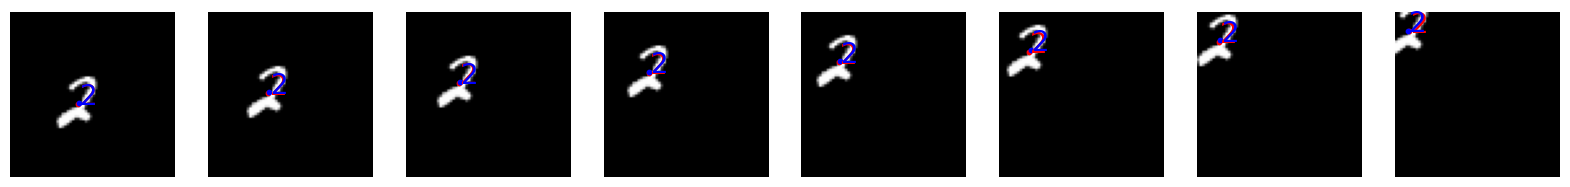

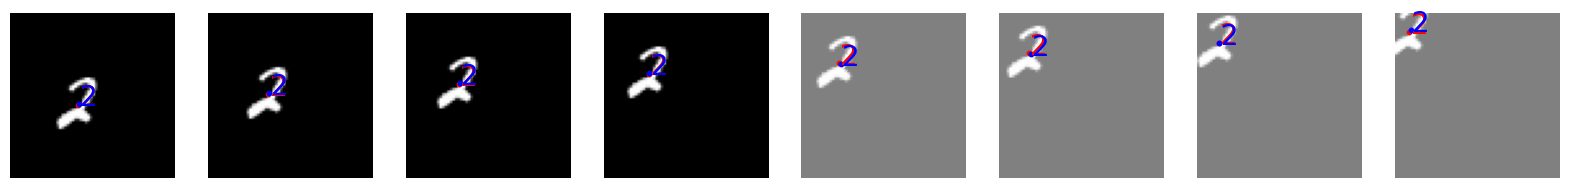

In [80]:
# for i, drop in enumerate(args.frame_dropout_pattern):
#     targets_flat[i]['keep_frame'] = torch.tensor([int(drop)])
    
#     print(drop)

# print(targets)


idx = 55

sequence, targets = ds_default[idx]
#sequence_blind, targets_blind = ds_blind[idx]

targets = [
    [{k: v.to(device) for k, v in t.items()} for t in targets]
]

sequence = sequence.unsqueeze(0).to(device)

out, targets_flat = model(sequence, targets)

show_sequence(sequence, targets_flat, out, ds_default, show_images, show_prediction=True)

for i, drop in enumerate(args.frame_dropout_pattern):
    targets_flat[i]['keep_frame'] = torch.tensor([1 - int(drop)])

out, targets_flat = model(sequence, targets)

show_sequence(sequence, targets_flat, out, ds_default, show_images, show_prediction=True)

In [59]:
idx = 10

sequence, targets = ds_default[idx]
sequence_blind, targets_blind = ds_blind[idx]

targets = [
    [{k: v.to(device) for k, v in t.items()} for t in targets]
]

targets_blind = [
    [{k: v.to(device) for k, v in t.items()} for t in targets_blind]
]

sequence = sequence.unsqueeze(0).to(device)
sequence_blind = sequence_blind.unsqueeze(0).to(device)

out, targets_flat = model(sequence, targets)
out_blind, targets_flat_blind = model(sequence_blind, targets_blind)

ade = AverageDisplacementErrorEvaluator(
          output_dir=f'{output_dir}/test_ade_defalt_epoch-{epoch}.png',
          prefix='default',
          matcher=criterion.matcher,
          img_size=ds_blind.img_size,
        )


ade_blind = AverageDisplacementErrorEvaluator(
          output_dir=f'{output_dir}/test_ade_blind_epoch-{epoch}.png',
          prefix='blind',
          matcher=criterion.matcher,
          img_size=ds_blind.img_size,
        )

NameError: name 'ds_blind' is not defined

In [29]:
ade.update(*postprocessors['trajectory'](out, targets_flat))
ade.accumulate()
r = ade.summary()
r

{'default_ADE_0': 0.5303423404693604,
 'default_ADE_1': 0.2678205966949463,
 'default_ADE_2': 0.4827596843242645,
 'default_ADE_3': 0.43848681449890137,
 'default_ADE_4': 0.26353681087493896,
 'default_ADE_5': 0.2926582098007202,
 'default_ADE_6': 0.6143808960914612,
 'default_ADE_7': 0.46977436542510986}

In [30]:
ade.update(*postprocessors['trajectory'](out_blind, targets_flat_blind))
ade.accumulate()
r = ade.summary()
r

{'default_ADE_0': 0.5303423404693604,
 'default_ADE_1': 0.2678205966949463,
 'default_ADE_2': 0.4827596843242645,
 'default_ADE_3': 0.43848681449890137,
 'default_ADE_4': 0.4977521598339081,
 'default_ADE_5': 0.5593279600143433,
 'default_ADE_6': 0.7625422477722168,
 'default_ADE_7': 0.8984476923942566}